# Kings County Housing Prices Bakeoff

Below are a list of steps that you should take while trying to complete your bake-off entry.

In [221]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import math
# pd.options.display.max_columns = None
%matplotlib inline

## Step 1: Read in Data

In [222]:
house_train = pd.read_csv('data/kc_house_data_train.csv', index_col = 0)
house_train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,2591820310,20141006T000000,365000.0,4,2.25,2070,8893,2.0,0,0,4,8,2070,0,1986,0,98058,47.4388,-122.162,2390,7700
1,7974200820,20140821T000000,865000.0,5,3.00,2900,6730,1.0,0,0,5,8,1830,1070,1977,0,98115,47.6784,-122.285,2370,6283
2,7701450110,20140815T000000,1038000.0,4,2.50,3770,10893,2.0,0,2,3,11,3770,0,1997,0,98006,47.5646,-122.129,3710,9685
3,9522300010,20150331T000000,1490000.0,3,3.50,4560,14608,2.0,0,2,3,12,4560,0,1990,0,98034,47.6995,-122.228,4050,14226
4,9510861140,20140714T000000,711000.0,3,2.50,2550,5376,2.0,0,0,3,9,2550,0,2004,0,98052,47.6647,-122.083,2250,4050


In [164]:
house_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17290 entries, 0 to 17289
Data columns (total 21 columns):
id               17290 non-null int64
date             17290 non-null object
price            17290 non-null float64
bedrooms         17290 non-null int64
bathrooms        17290 non-null float64
sqft_living      17290 non-null int64
sqft_lot         17290 non-null int64
floors           17290 non-null float64
waterfront       17290 non-null int64
view             17290 non-null int64
condition        17290 non-null int64
grade            17290 non-null int64
sqft_above       17290 non-null int64
sqft_basement    17290 non-null int64
yr_built         17290 non-null int64
yr_renovated     17290 non-null int64
zipcode          17290 non-null int64
lat              17290 non-null float64
long             17290 non-null float64
sqft_living15    17290 non-null int64
sqft_lot15       17290 non-null int64
dtypes: float64(5), int64(15), object(1)
memory usage: 2.9+ MB


## Step 2: Exploratory Data Analysis 
    
Become familiar with the data.  Look to see if there are any extreme values.  

Additionally create data visualizations to determine if there are any relationships between your features and your target variables.  

In [23]:
# No missing values
# house_train.isnull().sum()

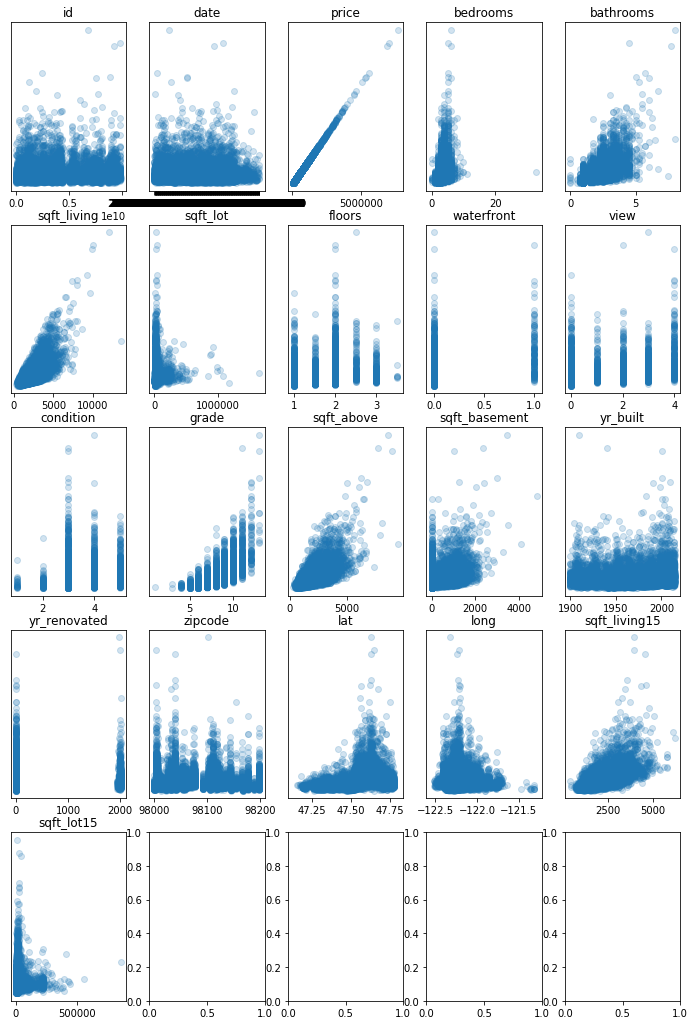

In [24]:
# for each columns, plot scatter plot

def mass_scatter(df, y = 'price'):
    a = len(df.columns)
    ncols = math.ceil(a**.5)
    nrows = math.ceil(a/ncols)
    fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (12, 18))

    axes = axes.ravel() 

    for i in range(len(df.columns)):
        axes[i].scatter(df.iloc[:, i], df[y], alpha = 0.2)
        axes[i].set_title(df.columns[i])
        axes[i].get_yaxis().set_ticks([])

mass_scatter(house_train)

### Observation
#### Outliers
1. There is one outlier that has extremely many bedroom. 
2. Some price points are very high and weakening relationships, we should remove them.
3. There's a very large lot in the data set. We should check that's not an outlier.

#### Missing Info
1. Location is a valuable information. We have zipcode and long/lat to approximate the location info. 
- Add zipcode in as categorical and filter out to ones that matter. 
- Make an interaction of long/lat as a feature
2. Year renovated is perhaps important feature but is not applicable for most datapoints. We should create a new variable 'year_old' that counts the age of the house. Check interaction of this with Condition variable.
3. Basement - it seems like many are missing basement value. So I'll create a binary column for whether basement exist or not and add in as a feature.


### Outliers
#### 1. too many bedroom
There's a house with 30+ bedrooms. Let's take a look at that.

In [223]:
house_train[house_train.bedrooms > 20]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
8597,2402100895,20140625T000000,640000.0,33,1.75,1620,6000,1.0,0,0,5,7,1040,580,1947,0,98103,47.6878,-122.331,1330,4700


It's likely that 33 bedrooms is an input error of 3, since it's a small place with less than 2 bathrooms. We will change that value to more appropriate number.

In [224]:
round((house_train.bedrooms/house_train.sqft_living).median()*1620)

# median # of bedroom per sqft.living multiplied by sqft.living 
house_train.at[8597, 'bedrooms'] = 3

#### 2. Price outliers
Some houses seem to be extremely expensive. Let's take a look.

#### Price distribution

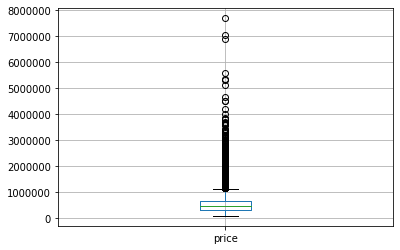

In [225]:
house_train.boxplot(['price']) # some extreme values. Maybe we should remove them.

In [168]:
house_train.sort_values(by = 'price', ascending = False)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
10366,6762700020,20141013T000000,7700000.0,6,8.00,12050,27600,2.5,0,3,...,13,8570,3480,1910,1987,98102,47.6298,-122.323,3940,8800
6903,9808700762,20140611T000000,7062500.0,5,4.50,10040,37325,2.0,1,2,...,11,7680,2360,1940,2001,98004,47.6500,-122.214,3930,25449
7519,9208900037,20140919T000000,6885000.0,6,7.75,9890,31374,2.0,0,4,...,13,8860,1030,2001,0,98039,47.6305,-122.240,4540,42730
2232,2470100110,20140804T000000,5570000.0,5,5.75,9200,35069,2.0,0,0,...,13,6200,3000,2001,0,98039,47.6289,-122.233,3560,24345
1979,8907500070,20150413T000000,5350000.0,5,5.00,8000,23985,2.0,0,4,...,12,6720,1280,2009,0,98004,47.6232,-122.220,4600,21750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1269,1623049041,20140508T000000,82500.0,2,1.00,520,22334,1.0,0,0,...,5,520,0,1951,0,98168,47.4799,-122.296,1572,10570
15956,3883800011,20141105T000000,82000.0,3,1.00,860,10426,1.0,0,0,...,6,860,0,1954,0,98146,47.4987,-122.341,1140,11250
9193,8658300340,20140523T000000,80000.0,1,0.75,430,5050,1.0,0,0,...,4,430,0,1912,0,98014,47.6499,-121.909,1200,7500
4869,40000362,20140506T000000,78000.0,2,1.00,780,16344,1.0,0,0,...,5,780,0,1942,0,98168,47.4739,-122.280,1700,10387


#### Log Price distribution  

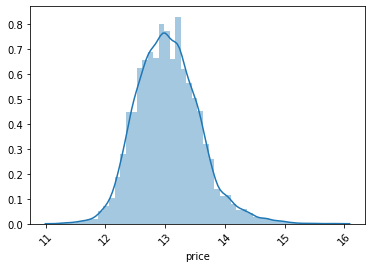

In [169]:
sns.distplot(np.log(house_train.price))
plt.xticks(rotation=45)
plt.show()

In [170]:
# removing outliers with log price value higher than 4 log std.
log_filt = np.log(house_train.price).mean() + np.log(house_train.price).std()*4
len(house_train[np.log(house_train.price)>= log_filt])

13

In [171]:
# not removing it yet ()
# house_train = house_train[np.log(house_train.price) < log_filt]

### 3. Large lot

In [172]:
house_train.sort_values(by = 'sqft_lot', ascending = False)
# it seems like it's a large lot and a very small house. 
# I have no evidence to think this is an error. 
# We will keep it for now.

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
718,1020069017,20150327T000000,700000.0,4,1.00,1300,1651359,1.0,0,3,...,6,1300,0,1920,0,98022,47.2313,-122.023,2560,425581
11616,3326079016,20150504T000000,190000.0,2,1.00,710,1164794,1.0,0,0,...,5,710,0,1915,0,98014,47.6888,-121.909,1680,16730
13460,2623069031,20140521T000000,542500.0,5,3.25,3010,1074218,1.5,0,0,...,8,2010,1000,1931,0,98027,47.4564,-122.004,2450,68825
16243,2323089009,20150119T000000,855000.0,4,3.50,4030,1024068,2.0,0,0,...,10,4030,0,2006,0,98045,47.4619,-121.744,1830,11700
13543,722069232,20140905T000000,998000.0,4,3.25,3770,982998,2.0,0,0,...,10,3770,0,1992,0,98058,47.4140,-122.087,2290,37141
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5741,7899800864,20150305T000000,259950.0,2,2.00,1070,649,2.0,0,0,...,9,720,350,2008,0,98106,47.5213,-122.357,1070,928
5944,688000017,20140627T000000,516500.0,1,1.25,1100,638,3.0,0,0,...,9,1100,0,2014,0,98112,47.6228,-122.307,1110,1933
2682,7899800857,20141215T000000,256950.0,2,2.00,1070,635,2.0,0,0,...,9,720,350,2008,0,98106,47.5212,-122.357,1070,928
644,6371000026,20150122T000000,367500.0,2,2.00,1030,600,2.0,0,0,...,8,680,350,2004,0,98116,47.5788,-122.410,1120,1267


### Features (New columns)
Now I'll create new columns I need. From here on, I will need to be able to replicate, so I'll create them as a function.

#### Year_old
Either year since renovated or since built

In [227]:
def make_yearold (df):
    df['year_old'] = np.where(df.yr_renovated == 0, 
                                   df.yr_built, df.yr_renovated)
    return df
house_train = make_yearold (house_train)

#### Basement
Add a column that shows whether there is a basement or not. 

In [228]:
def make_basement(df):
    df['basement'] = np.where(df.sqft_basement > 0, 1, 0)
    return df

house_train = make_basement(house_train)

#### Date
I'm not entirely sure what 'date' columns is supposed to be. But we can separate out month and year and see if they have any effect on our model.

In [229]:
def make_dates(df):
    df['month'] = df.date.apply(lambda x: int(x[4:6]))
    df['yr'] = df.date.apply(lambda x: int(x[0:4]))
    df.date = df.date.apply(lambda x: int(x[0:8]))
    df.date = pd.to_datetime(df.date, format = "%Y%m%d")
    return df
house_train = make_dates(house_train)

In [176]:
# change date
# house_train.date = pd.to_datetime(house_train.date, format = "%Y%m%d")

## Status Check

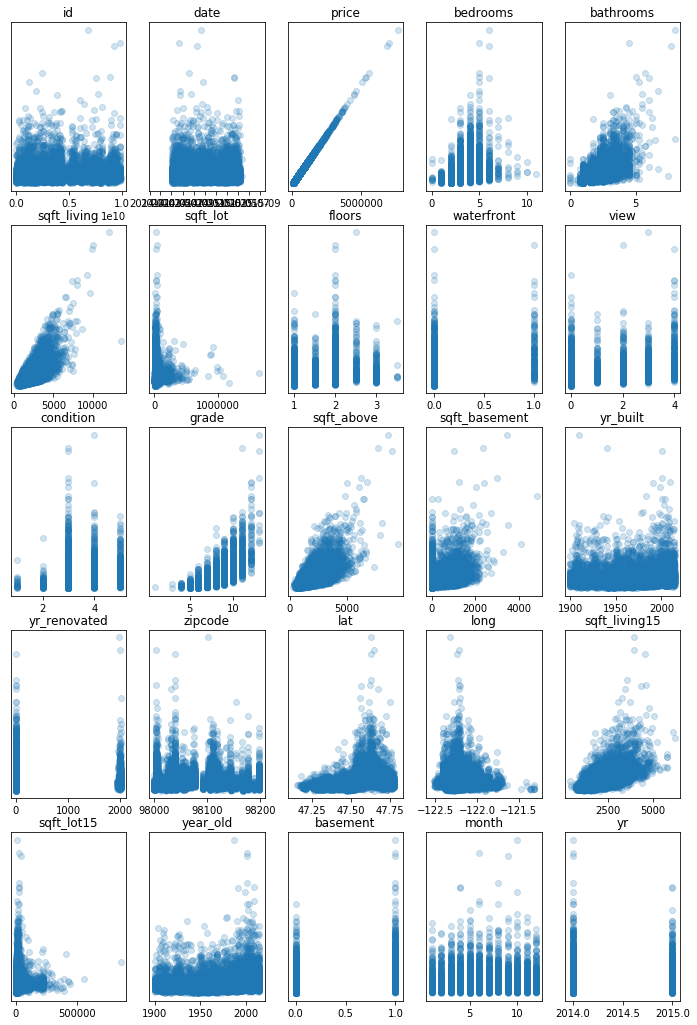

In [37]:
mass_scatter(house_train)

## Baseline Model

We will check for assumptions and create a baseline model here. And then we will investigate interactions and other feature selection to see if any improves our model.

### Scale, transform data, and add dummy columns

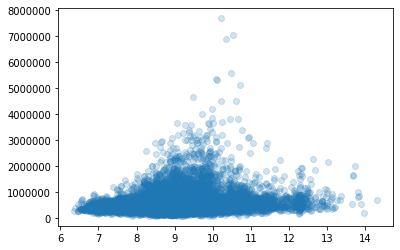

In [44]:
# sqft_lot seemed to have exponential decay relationship to price. So transferring to log.
# Can't say with confidence that this is linear relationship...???
plt.scatter(np.log(house_train.sqft_lot), house_train.price, alpha = 0.2)

In [177]:
def dummies(x, prefix):
    """
    Helper function to make dummies
    Input: series or array, prefix string
    Output: dummy dataframe
    """
    dummy = pd.get_dummies(x, prefix = prefix, drop_first = True)
    return dummy

In [178]:
def standardize(x):
    """
    Helper function to standardize scalar values
    Input: series or numpy array 
    Output: original input as standardized version ((x-mean(x))/std(x))
    """
    return (x - x.mean())/x.std()

In [179]:
def remove_feat(df, exc_list):
    df.drop(exc_list, axis = 1, inplace = True)
    return df

In [230]:
# columns to remove


def df_transformation(df, exc_list, catvals, target = 'price'):
    
    y = df[target]
    X = df.drop(target, axis = 1).copy()
    
    # drop exclusion lists
    X = remove_feat(X, exc_list)
    
    # log transformation
    logvals = ['sqft_lot']
    for item in logvals: 
        X[item] = np.log(X[item])
    
    # categorical values to turn into dummies
    for col in X.columns: 
        if col in catvals:
            dummy = dummies(X[col], col[0:3])
            X = pd.concat([X, dummy], axis = 1)
            X.drop(col, axis = 1, inplace = True)    
    return X, y
    
    

In [231]:
exc_list = ['id', 'date', 'sqft_living15', 'sqft_lot15', 'yr_built', 
           'yr_renovated', 'month', 'yr']
catvals = ['floors', 'waterfront', 'view', 'condition', 'grade', 'basement', 'zipcode']

X, y = df_transformation(house_train, exc_list, catvals)

In [182]:
X

,bedrooms,bathrooms,sqft_living,sqft_lot,sqft_above,sqft_basement,lat,long,year_old,flo_1.5,...,zip_98148,zip_98155,zip_98166,zip_98168,zip_98177,zip_98178,zip_98188,zip_98198,zip_98199,bas_1
0,4,2.25,2070,9.093020,2070,0,47.4388,-122.162,1986,0,...,0,0,0,0,0,0,0,0,0,0
1,5,3.00,2900,8.814330,1830,1070,47.6784,-122.285,1977,0,...,0,0,0,0,0,0,0,0,0,1
2,4,2.50,3770,9.295876,3770,0,47.5646,-122.129,1997,0,...,0,0,0,0,0,0,0,0,0,0
3,3,3.50,4560,9.589325,4560,0,47.6995,-122.228,1990,0,...,0,0,0,0,0,0,0,0,0,0
4,3,2.50,2550,8.589700,2550,0,47.6647,-122.083,2004,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17285,5,2.50,3240,9.206332,2020,1220,47.5858,-122.112,1958,0,...,0,0,0,0,0,0,0,0,0,1
17286,2,1.75,1300,8.294050,1300,0,47.6687,-122.288,1948,0,...,0,0,0,0,0,0,0,0,0,0
17287,3,1.00,1050,9.197863,1050,0,47.7635,-122.262,1953,0,...,0,0,0,0,0,0,0,0,0,0
17288,3,1.50,1900,10.673272,1300,600,47.4199,-121.990,1971,1,...,0,0,0,0,0,0,0,0,0,1


### Check for multicollinearity

In [232]:
def corr_high(df):
    corr_df = abs(df.corr()).stack().reset_index()
    corr_df.columns = ['v1', 'v2', 'c']
    return corr_df, corr_df[(corr_df.c > 0.7) & (corr_df.c < 1)].sort_values(
        by = 'c', ascending = False)

corr_high(X)[1]

,v1,v2,c
212,sqft_living,sqft_above,0.876696
418,sqft_above,sqft_living,0.876696
623,sqft_basement,bas_1,0.818269
10717,bas_1,sqft_basement,0.818269
2101,con_3,con_4,0.810849
2204,con_4,con_3,0.810849
106,bathrooms,sqft_living,0.755270
209,sqft_living,bathrooms,0.755270


It seems like condition 3 and 4 are highly correlated. We will drop condition 4 for now.  
We will also drop sqft_living, which is highly correlating with a lot of other measures.  


### Remove features

In [233]:
exc_list = ['sqft_living', 'con_4']
X = remove_feat(X, exc_list)

### Run baseline model

In [234]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

def lin_avg_crossval(X, y):
    regression = LinearRegression()
    crossvalidation = KFold(n_splits=3, shuffle=True, random_state=1)
    return np.mean(cross_val_score(regression, X, y, scoring='r2', cv=crossvalidation))


baseline = lin_avg_crossval(X, y)
baseline

0.8272658412773503

Current baseline score is .827. Let's try to add some interactions and polynomials.

## Interactions

I think there is a relationship between condition and year_old. Let's plot them to see if there's any interaction effect on price.

1. Condition & year_old
2. Waterfront & view

Before we begin, I'll see if there's any other interactions to use.

In [189]:
# code from Learn.co turned to a function
from itertools import combinations

def find_interactions(X, y):
    interactions = []
    feature_comb = combinations(X.columns, 2) # all pairs
    data = X.copy()
    reg = LinearRegression()
    crossvalidation = KFold(n_splits = 10, shuffle = True, random_state = 1)

    for i, (a, b) in enumerate(feature_comb):
        data['interaction'] = data[a] * data[b]
        score = np.mean(cross_val_score(reg, data, y, scoring = 'r2', cv = crossvalidation))
        if score > baseline: 
            interactions.append((a, b, round(score, 3)))
        if i % 50 == 0: 
            print (i) # tally
    return interactions

In [198]:
# This would take forever so skip it for now.
# interactions = find_interactions(X, y)

In [128]:
sorted(interactions, key = lambda inter: inter[2], reverse = True)[0:5]

[('sqft_above', 'wat_1', 0.723),
 ('bathrooms', 'wat_1', 0.722),
 ('sqft_above', 'bas_1', 0.722),
 ('sqft_above', 'long', 0.72),
 ('long', 'gra_11', 0.72)]

Additionally it seems like sqft seems to interact a lot with others.  
It's reasonable to believe that sqft_above and waterfront or existence of basement is interacting.  
We will add these top threes after reviewing their trendlines.

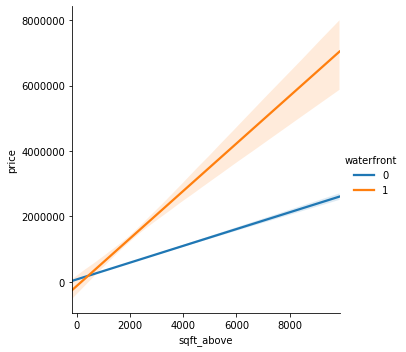

In [199]:
sns.lmplot(x="sqft_above", y="price", hue="waterfront", data=house_train, scatter = False);

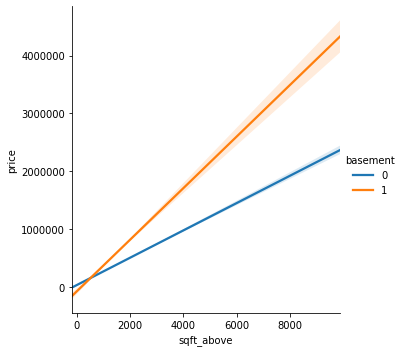

In [200]:
sns.lmplot(x="sqft_above", y="price", hue="basement", 
           data=house_train, scatter = False);

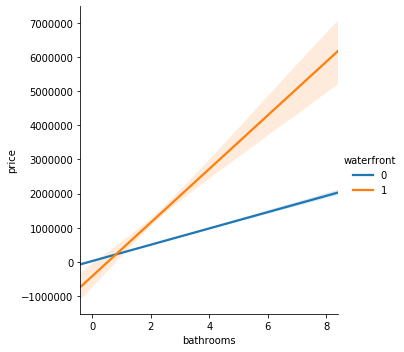

In [201]:
sns.lmplot(x="bathrooms", y="price", hue="waterfront", 
           data=house_train, scatter = False);

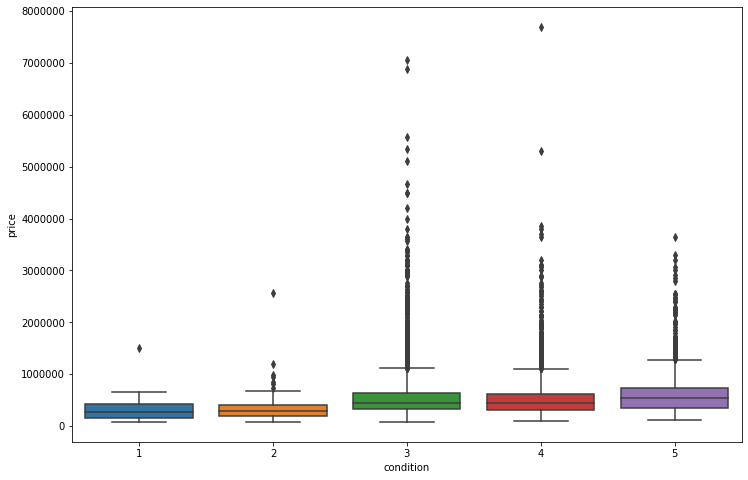

In [202]:
# I want to look closely how individual condition relationship to price.
# I want to combine some of these if their relationship is similar

plt.figure(figsize = (12, 8))
sns.boxplot(x = "condition", y = "price", data = house_train)

# I think we can combine condition (1, 2), (3, 4), 5

### Combining conditions
I'm going to combine condition 1, 2 and 3, 4.

In [235]:
# I'm flipping the numbers so it will drop the highest condition later.
house_train.condition = np.where((house_train.condition == 1) | (house_train.condition == 2), '3', 
        np.where(house_train.condition == 5, 2, 1))

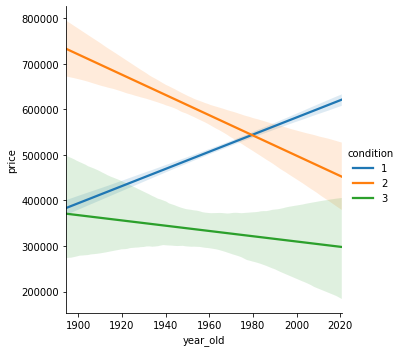

In [236]:
sns.lmplot(x="year_old", y="price", hue="condition", 
           data=house_train, scatter = False);

It seems like when condition is 3 or 5, there's some interaction with it between years. We'll apply this after separating out the dummy variables.

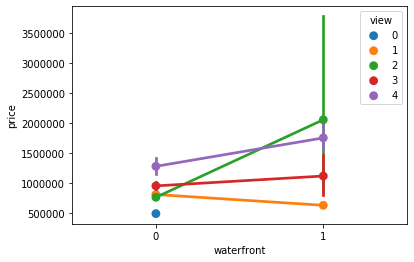

In [205]:
sns.pointplot(x="waterfront", y="price", hue="view", data=house_train);

No strong interaction observed.

## Did combining conditions helped? 

In [243]:
exc_list = ['id', 'date', 'sqft_living15', 'sqft_lot15', 'yr_built', 
           'yr_renovated', 'month', 'yr']
catvals = ['floors', 'waterfront', 'view', 'grade', 'basement', 'zipcode', 'condition']

X, y = df_transformation(house_train, exc_list, catvals)

corr_high(X)[1]

,v1,v2,c
208,sqft_living,sqft_above,0.876696
410,sqft_above,sqft_living,0.876696
611,sqft_basement,bas_1,0.818269
10307,bas_1,sqft_basement,0.818269
104,bathrooms,sqft_living,0.755270
205,sqft_living,bathrooms,0.755270


In [244]:
exc_list = ['sqft_living']
X = remove_feat(X, exc_list)

In [245]:
print(f"New: {lin_avg_crossval(X, y)}, Bseline: {baseline}")
# Changing categories alone made it slightly worse. 

New: 0.8268224558725485, Bseline: 0.8272658412773503


Add interaction between discussed measures.

In [253]:
def add_interaction(df, x1, x2):
    """
    Input: x1, x2 are column names (string)
    Output: dataframe
    """
    new_var = 'x'.join([x1, x2])
    df[new_var] = df[x1] * df[x2]
    return df

In [254]:
def add_mlt_interaction(df, interaction):
    for item in interaction: 
        df = add_interaction(df, item[0], item[1])
    return df

In [249]:
X

,bedrooms,bathrooms,sqft_lot,sqft_above,sqft_basement,lat,long,year_old,flo_1.5,flo_2.0,flo_2.5,flo_3.0,flo_3.5,wat_1,vie_1,vie_2,vie_3,vie_4,con_2,con_3,gra_3,gra_4,gra_5,gra_6,gra_7,gra_8,gra_9,gra_10,gra_11,gra_12,gra_13,zip_98002,zip_98003,zip_98004,zip_98005,zip_98006,zip_98007,zip_98008,zip_98010,zip_98011,zip_98014,zip_98019,zip_98022,zip_98023,zip_98024,zip_98027,zip_98028,zip_98029,zip_98030,zip_98031,zip_98032,zip_98033,zip_98034,zip_98038,zip_98039,zip_98040,zip_98042,zip_98045,zip_98052,zip_98053,zip_98055,zip_98056,zip_98058,zip_98059,zip_98065,zip_98070,zip_98072,zip_98074,zip_98075,zip_98077,zip_98092,zip_98102,zip_98103,zip_98105,zip_98106,zip_98107,zip_98108,zip_98109,zip_98112,zip_98115,zip_98116,zip_98117,zip_98118,zip_98119,zip_98122,zip_98125,zip_98126,zip_98133,zip_98136,zip_98144,zip_98146,zip_98148,zip_98155,zip_98166,zip_98168,zip_98177,zip_98178,zip_98188,zip_98198,zip_98199,bas_1
0,4,2.25,9.093020,2070,0,47.4388,-122.162,1986,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,5,3.00,8.814330,1830,1070,47.6784,-122.285,1977,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,4,2.50,9.295876,3770,0,47.5646,-122.129,1997,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,3.50,9.589325,4560,0,47.6995,-122.228,1990,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,3,2.50,8.589700,2550,0,47.6647,-122.083,2004,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17285,5,2.50,9.206332,2020,1220,47.5858,-122.112,1958,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
17286,2,1.75,8.294050,1300,0,47.6687,-122.288,1948,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
17287,3,1.00,9.197863,1050,0,47.7635,-122.262,1953,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
17288,3,1.50,10.673272,1300,600,47.4199,-121.990,1971,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [256]:
interaction = [('sqft_above', 'wat_1'), ('bathrooms', 'wat_1'), ('sqft_above', 'bas_1'), 
              ('year_old', 'con_3')]
X = add_mlt_interaction(X, interaction)

In [258]:
lin_avg_crossval(X, y)

0.8438034515481139

## Adding interactions
It improved the model.

## Polynomial
Lat & Long are definitely not linear relationship. Let's see if we can transform these dataset.

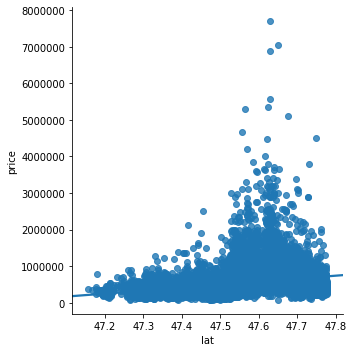

In [262]:
sns.lmplot(x = 'lat', y = 'price', data = house_train)

### Non-linear transformations

### 4.4) Create a polynomial feature for two of your continuous variables


In [ ]:
# your code here

### 4.5) Create an interaction feature between a binary variable (dummy variable) and a continuous variable) 

In [ ]:
# your code here

## Step 5: Train Test Split

If you plan on doing any sclaing of your data, make sure it is doen at the apporpriate time. 

Since we will be re-running this process again, I'll write it as a function.  

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

# function to fit the model

def generate_XY(df, y_col = 'price'):
    """
    input: dataframe and column name of outcome variable
    return: fitted model and print summary
    """
    y = df[y_col]
    X = df.drop(y_col, axis = 1)
    
    return X, y


### 5.1) Perform a train test split of the data.

In [ ]:
# function to split the data 
from sklearn.model_selection import train_test_split

def split_df (df, y_col = 'price', test_size = 0.2, random_state = 42):
    """
    input: df and name of outcome column
    return: train, test for x and y
    """
    X, y = generate_XY(df, y_col)
    return train_test_split(X, y, test_size=test_size, random_state=random_state)



### 5.4) Fit the model to the training data.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

def linfit(df, y_col = 'price', test_size = 0.2, random_state = 42):
    """
    split the data and fit model
    return y_train, y_test, y_pred_train, y_pred_test, print prediction errors
    """
    X_train, X_test, y_train, y_test = split_df(df, y_col, test_size, random_state)
    linreg = LinearRegression()

    linreg.fit(X_train, y_train)
        
    y_pred_train = linreg.predict(X_train)
    y_pred_test = linreg.predict(X_test)
    
    train_mse = mean_squared_error(y_train, y_pred_train)
    test_mse = mean_squared_error(y_test, y_pred_test)
    
    print('Train RMSE:', np.sqrt(train_mse))
    print('Test RMSE:', np.sqrt(test_mse))
    
    return y_train, y_test, y_pred_train, y_pred_test

In [ ]:
y_train, y_test, y_pred_train, y_pred_test = linfit(scaled_df)

### 5.7) Determine if your model is overfit.

In [ ]:
sns.distplot((y_train-y_pred_train)**2, hist = False, label = 'train')
sns.distplot((y_test-y_pred_test)**2, hist = False, label = 'test')
plt.xlabel("MSE")

## Step 6: Utilize some different feature selection techniques before or in conjuction with fitting your models

### 6.1) Utilize a filter method to identify some features to remove from the model.  

In [ ]:
## Code from Learn.co
import statsmodels.api as sm

def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included


In [ ]:
X, y = generate_XY(scaled_df)
result = stepwise_selection(X, y, verbose=True)
print('resulting features:')
print(result)

In [ ]:
#from sklearn.datasets import make_friedman1
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
selector = RFE(linreg, n_features_to_select=4)
selector = selector.fit(X, y)
X.columns[selector.support_]

### 6.2) After removing the features, rerun steps 5 and see if you r new model performs better than the old model.

In [ ]:
# your code here

## Step 7: Evaluate your different models in order to determine the best model overall

## Step 8:  Refit your best model to the entire dataset

## Step 9: Save your final model using pickle

https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/

In [ ]:
import pickle
# Save
#with open('final_model.pickle', 'wb') as f:
#    pickle.dump(reg, f)
